Dataset

In [34]:
!pip install tqdm
import numpy as np
import pandas as pd
import tarfile
import tqdm
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [28]:
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt -O lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O lfw.tgz

# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"
# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"

--2021-12-12 17:49:07--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-12-12 17:49:07--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  29.2MB/s    in 0.5s    

2021-12-12 17:49:08 (29.2 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2021-12-12 17:49:08--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu

In [29]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

Normalising the raw pixel data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/18983 [00:00<?, ?it/s]

0.5 -0.5


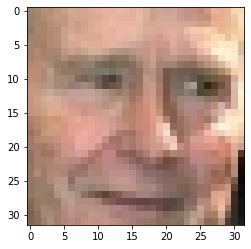

In [35]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
X = X.astype('float32') / 255.0 - 0.5
print(X.max(), X.min())


def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

show_image(X[3])

Splitting the dataset into train and test set

In [36]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

Building the model for autoencoder

In [38]:
ENCODING_VEC_SIZE = 1000

def build_autoencoder(img_shape, encoding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(encoding_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((encoding_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder


# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, ENCODING_VEC_SIZE)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 1000)              3073000   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         3075072   
                                                                 
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

Epoch 1/20
370/370 [==============================] - 26s 70ms/step - loss: 0.0086 - val_loss: 0.0044
Epoch 2/20
370/370 [==============================] - 26s 69ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 3/20
370/370 [==============================] - 26s 69ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/20
370/370 [==============================] - 26s 70ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/20
370/370 [==============================] - 25s 69ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/20
370/370 [==============================] - 25s 68ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
370/370 [==============================] - 25s 68ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/20
370/370 [==============================] - 25s 69ms/step - loss: 8.9674e-04 - val_loss: 8.6074e-04
Epoch 9/20
370/370 [==============================] - 25s 69ms/step - loss: 7.9198e-04 - val_loss: 8.2695e-04
Epoch 10/20
370/370 [==============================] - 26s 71ms/st

Plotting/Visualizing the loss

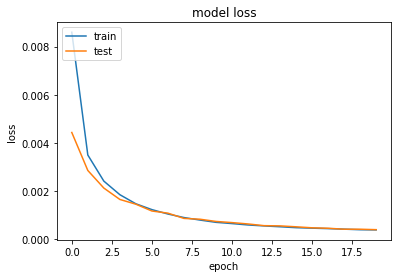

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Visualizing the Results of the autoencoder

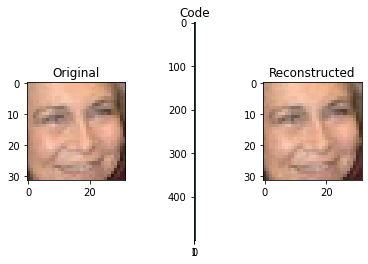

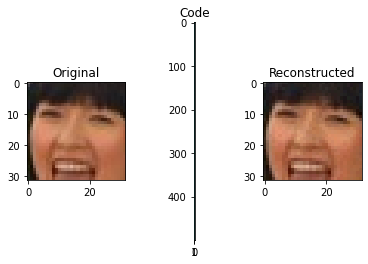

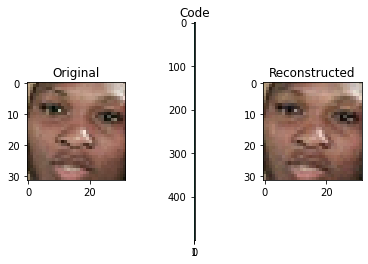

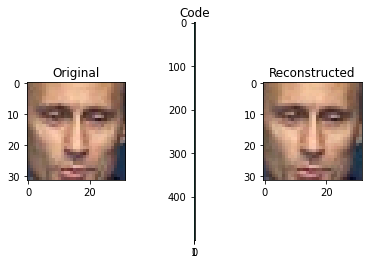

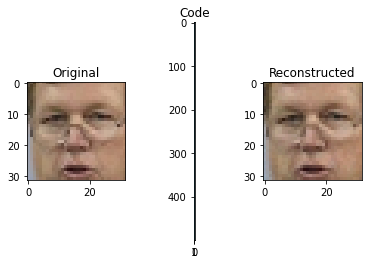

In [41]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

Adding Noise to the image to learn Denoising

In [42]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise




Visualizing the impact of adding noise with different values of sigma

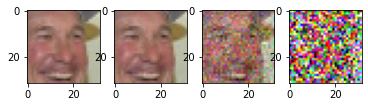

In [43]:
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [44]:
encoder, decoder = build_autoencoder(IMG_SHAPE, encoding_size=ENCODING_VEC_SIZE)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/25, Generating corrupted samples...
370/370 [==============================] - 26s 70ms/step - loss: 0.0142 - val_loss: 0.0083
Epoch 2/25, Generating corrupted samples...
370/370 [==============================] - 28s 75ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 3/25, Generating corrupted samples...
370/370 [==============================] - 26s 71ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/25, Generating corrupted samples...
370/370 [==============================] - 26s 71ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/25, Generating corrupted samples...
370/370 [==============================] - 27s 73ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/25, Generating corrupted samples...
370/370 [==============================] - 27s 74ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/25, Generating corrupted samples...
370/370 [==============================] - 26s 72ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/25, Generating corrupted samples...
370/370 [==

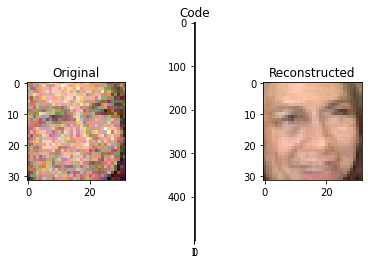

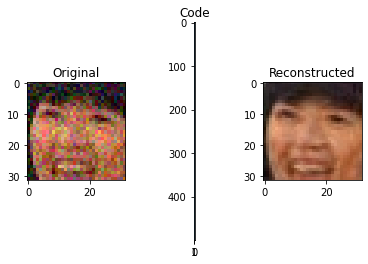

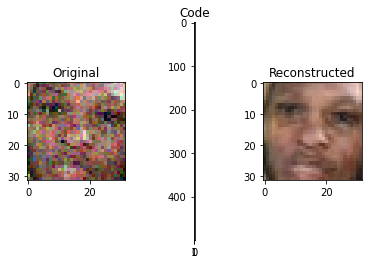

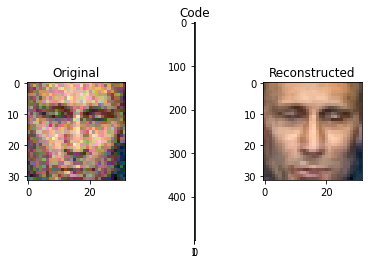

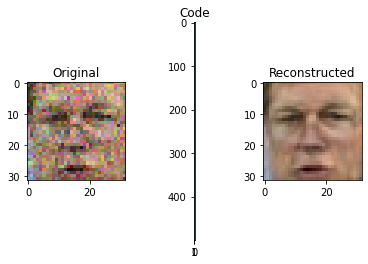

In [45]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)